# Exercise 2 - NYC Citi Bikes data analysis
#### author: Michał Gozdera

02/03/2022

## Introduction

This is a report concerning Citi Bikes in New York data analysis. Made for Data Exploration and Visualization Classes (WUT 2022).

## Used data description

From the Citi Bike website (https://ride.citibikenyc.com/system-data)
Where do Citi Bikers ride? When do they ride? How far do they go? Which stations are most
popular? What days of the week are most rides taken on? We’ve heard all of these questions
and more from you, and we’re happy to provide the data to help you discover the answers to
these questions and more. We invite developers, engineers, statisticians, artists, academics and
other interested members of the public to use the data we provide for analysis, development,
visualization and whatever else moves you.

The Citi Bike trip data includes:

* Ride ID
* Rideable type
* Started at
* Ended at
* Start station name
* Start station ID
* End station name
* End station ID
* Start latitude
* Start longitude
* End latitude
* End Longitude
* Member or casual ride

Data can be downlowaded at
https://ride.citibikenyc.com/system-data

## Initial data preparation 

### Including all necessary libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import geopy.distance
import seaborn as sns    
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.4)

### Reading data, converting to datetime type

In [4]:
d = pd.read_csv("JC-202201-citibike-tripdata.csv")
d.started_at = pd.to_datetime(d.started_at, format="%Y-%m-%d %H:%M:%S")
d.ended_at = pd.to_datetime(d.ended_at, format="%Y-%m-%d %H:%M:%S")

### Data cleaning

Some data does not have the end_station_id assigned (may be invalid data or bikes that have not been returned):

In [5]:
np.where(pd.isnull(d))

(array([ 1525,  1525,  1525, ..., 26754, 26755, 26755], dtype=int64),
 array([ 6,  7, 10, ...,  7,  6,  7], dtype=int64))

In [6]:
d.loc[pd.isnull(d.end_station_id), ["ride_id", "end_station_id", "end_lat", "end_lng"]].head()

,ride_id,end_station_id,end_lat,end_lng
1525,C1CA3364B596CBE1,NaN,NaN,NaN
1728,199E7995B5B3A973,NaN,40.71,-74.03
1729,F743CEF311AA7617,NaN,40.72,-74.04
1730,2A5DEF6B3C50AD73,NaN,40.72,-74.03
1732,B3141502108CA01F,NaN,NaN,NaN


Let's skip them in the further analysis:

In [7]:
d = d.loc[~pd.isnull(d.end_station_id),]

No missing values now:

In [8]:
np.where(pd.isnull(d))

(array([], dtype=int64), array([], dtype=int64))

There also some data (10 records) with unusual (numerical) ids of end stations and small numbers of rentals assigned:

In [9]:
d.groupby("end_station_id").size().sort_index()[1:10]

end_station_id
5216.06    1
5492.05    1
6247.06    1
6441.01    1
6517.08    1
6765.01    1
6876.04    1
8358.10    2
8715.01    1
dtype: int64

However, they have names, lattitude and longitude so they seem to be valid (maybe e.g. some new stations):

In [10]:
idx = d.groupby("end_station_id").size().sort_index().index[1:10]
d.loc[d.end_station_id.isin(idx), ["ride_id", "end_station_id", "end_station_name", "end_lat", "end_lng"]]

,ride_id,end_station_id,end_station_name,end_lat,end_lng
663,CABB88E7258FB9F6,6517.08,W 42 St & 6 Ave,40.754920,-73.984550
735,67CA45B4B06AFED3,8358.10,Cabrini Blvd & W 177 St,40.848282,-73.941343
747,27FA9984127B2730,5216.06,Vesey St & Church St,40.712220,-74.010472
1385,2596894F5B060B5E,6441.01,Broadway & W 36 St,40.750977,-73.987654
4630,43C3AE5A497C39EC,6765.01,12 Ave & W 40 St,40.760875,-74.002777
6120,BF1B7B1E1961A87B,6247.06,W 27 St & 7 Ave,40.746647,-73.993915
6769,005F4C1DFA529458,8358.10,Cabrini Blvd & W 177 St,40.848282,-73.941343
11686,0DC56230E7A004E6,8715.01,Broadway & W 220 St,40.872412,-73.912807
12531,81B53734C6BA03E5,5492.05,Cleveland Pl & Spring St,40.722104,-73.997249
16523,E33C8E648F5D8000,6876.04,Central Park S & 6 Ave,40.765909,-73.976342


## Ex 1.4

### Frequency analysis

Here I analyze how often bikes are rented according to different criteria:

In [11]:
number_to_weekday = {
    0:"Monday", 
    1:"Tuesday", 
    2:"Wednesday", 
    3:"Thursday", 
    4:"Friday", 
    5:"Saturday", 
    6:"Sunday"
}

In [12]:
rides_per_hour = d.groupby(lambda idx: d.started_at[idx].hour).size().sort_index()
rides_per_month = d.groupby(lambda idx: d.started_at[idx].month).size().sort_index()
rides_per_day = d.groupby(lambda idx: d.started_at[idx].day).size().sort_index()
rides_per_weekday = d.groupby(lambda idx: d.started_at[idx].weekday()).size().sort_index() \
    .rename(index=number_to_weekday)

In [13]:
rides_per_day.head()

1     582
2    1232
3     819
4     922
5     911
dtype: int64

In [14]:
rides_per_month.head()

1    26359
dtype: int64

In [15]:
rides_per_day.head()

1     582
2    1232
3     819
4     922
5     911
dtype: int64

In [16]:
rides_per_weekday.head(7)

Monday       3920
Tuesday      3885
Wednesday    4449
Thursday     4425
Friday       3223
Saturday     2904
Sunday       3553
dtype: int64

### Stations analysis

In [17]:
stations = pd.merge(
    d.loc[:, ["start_station_id"]].groupby("start_station_id").size().rename("start_rental_couts"),
    d.loc[:, ["end_station_id"]].groupby("end_station_id").size().rename("end_rental_couts"),
    how = "outer",
    left_index = True,
    right_index = True
)
stations.fillna(0, inplace=True)
stations = stations.astype({"start_rental_couts": "int64", "end_rental_couts": "int64"})

In [18]:
stations.head(13)

,start_rental_couts,end_rental_couts
5065.10,0,1
5216.06,0,1
5492.05,0,1
6247.06,0,1
6441.01,0,1
6517.08,0,1
6765.01,0,1
6876.04,0,1
8358.10,0,2
8715.01,0,1


Let's check whether the number of rented bikes equals the number of returned bikes:

In [19]:
number_of_rented_bikes = np.sum(stations.start_rental_couts)
number_of_retuerned_bikes = np.sum(stations.end_rental_couts)
print(f"number of rented bikes: {number_of_rented_bikes}")
print(f"number of returned bikes: {number_of_retuerned_bikes}")
print(f"number of rented bikes == number of returned bikes?: {number_of_rented_bikes==number_of_retuerned_bikes}")

number of rented bikes: 26359
number of returned bikes: 26359
number of rented bikes == number of returned bikes?: True


### Rides analysis

Analysis according to rides (ride_info, rides_by_member_casual, rides_by_rideable_type, ride_meanduration_by_weekday_and_hour data.tables): 

In [20]:
ride_info = d.loc[:, ["ride_id", "started_at"]]
ride_info["duration_in_min"] = (d["ended_at"] - d["started_at"]).dt.total_seconds()/60
ride_info["dist_in_m"] = d.apply(lambda row: geopy.distance.distance((row.start_lat, row.start_lng), (row.end_lat, row.end_lng)).m, axis=1)
# average displacement speed in m/min
ride_info["speed_meters_per_min"] = ride_info.dist_in_m/ride_info.duration_in_min
# average displacement speed in km/h
ride_info["speed_km_per_h"] = ride_info.speed_meters_per_min * 0.06

In [21]:
ride_info.head()

,ride_id,started_at,duration_in_min,dist_in_m,speed_meters_per_min,speed_km_per_h
0,69D25C9A2BF4CD1E,2022-01-06 18:58:23,4.133333,743.046056,179.769207,10.786152
1,5F3B2B0055AE811B,2022-01-05 13:14:34,8.983333,996.712279,110.951274,6.657076
2,02A142745A00EBBA,2022-01-13 16:07:54,2.433333,403.074980,165.647252,9.938835
3,A62EFB4ED25D3E48,2022-01-06 15:45:41,6.383333,1168.152214,183.000347,10.980021
4,557DFA6EF22A8C1B,2022-01-16 15:36:30,16.900000,1343.560292,79.500609,4.770037


In [22]:
# rides counts by different types  
rides_by_member_casual = d.loc[:, ["member_casual"]].groupby("member_casual").size()
rides_by_rideable_type = d.loc[:, ["rideable_type"]].groupby("rideable_type").size()

In [23]:
rides_by_member_casual.head()

member_casual
casual     6598
member    19761
dtype: int64

In [24]:
rides_by_rideable_type.head()

rideable_type
classic_bike    26283
docked_bike        76
dtype: int64

In [25]:
# rides duration by the weekday and hour (taken values according to 0.9 quantile of duration to remove outliers obscuring visualization)
ride_info_q09 = ride_info.loc[ride_info.duration_in_min <= ride_info.duration_in_min.quantile(0.9), ]
ride_meanduration_by_weekday_and_hour = pd.DataFrame({
    "hour": ride_info_q09.started_at.dt.hour, 
    "weekday":  ride_info_q09.started_at.dt.weekday, # [number_to_weekday[weekday_number] for weekday_number in  ride_info_q09.started_at.dt.weekday],
    "duration": ride_info_q09.duration_in_min}).groupby(["hour", "weekday"]).mean()

In [26]:
ride_meanduration_by_weekday_and_hour.head(10)

duration
hour weekday          
0    0        6.615833
     1        5.764167
     2        5.606667
     3        5.172523
     4        5.169271
     5        6.639167
     6        6.456306
1    0        6.255263
     1        4.311111
     2        4.566667

## Ex 1.5

### Visualizing and exploring the frequency of bikes rentals 

Generic function plotting frequency barplots:

In [27]:
def plot_frequency(series,frequency_colname, mean_pos = 0, labels = False):
    ax = sns.barplot(x = series.index, y = series.values)
    ax.set_title("Bike rentals frequency analysis\n", fontsize=20, weight='bold')
    ax.axhline(np.mean(series.values), linestyle='--', color = "red")
    ax.text(mean_pos, np.mean(series.values)+20, "mean", color = "red")
    ax.set_xlabel('\n' +frequency_colname)
    ax.set_ylabel("rides count\n")
    if labels: ax.bar_label(ax.containers[0])
    return ax

Plots of subsequent charts: 

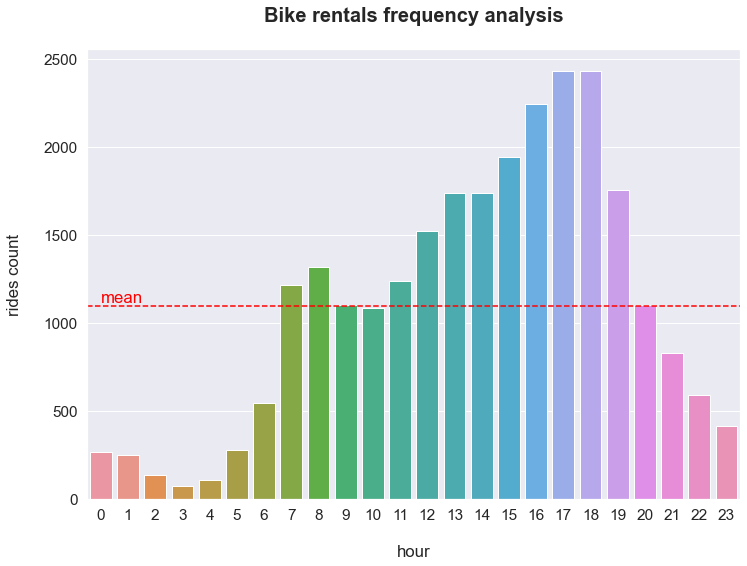

In [28]:
plot_frequency(rides_per_hour, "hour")
plt.show()

In the barplot above we can see that the majority of rentals is done in the afternoon (13:00-19:00) and 17:00 and 18:00 have the highest values of rented bikes. Probably people coming back from work of school use bikes. There is also a bit higher number of rentals (than the average) around 7:00 and 8:00 when New Yorkers tries to get to work or school. During the night there are not a lot of rentals, which is expected. 

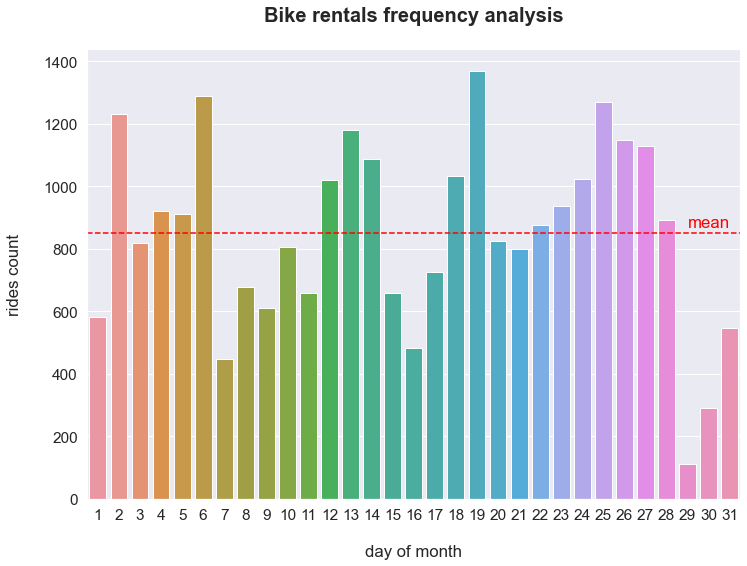

In [29]:
ax = plot_frequency(rides_per_day, "day", mean_pos=28)
ax.set_xlabel("\nday of month")
plt.show()

There is no clear dependency of the number of rentals by the day of the month. However, we can see some periodically recurring declines and increases. This may be causes by the day of the week so let’s plot this relationship in the next chart:

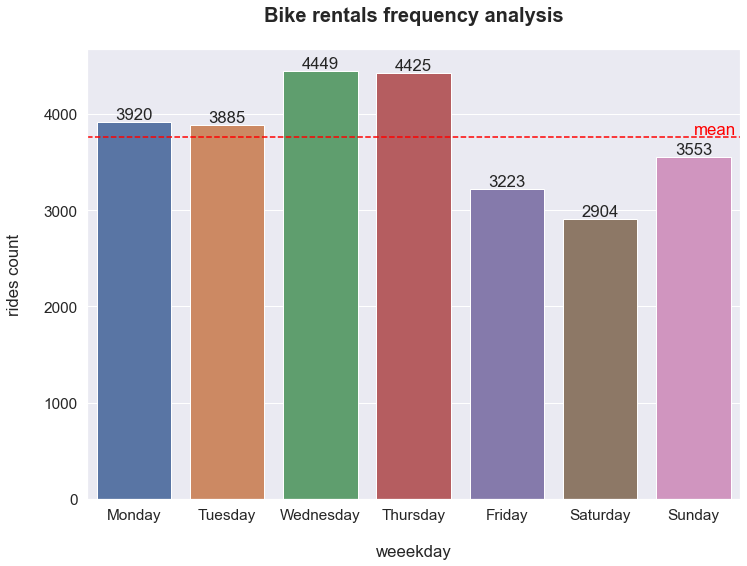

In [30]:
plot_frequency(rides_per_weekday, "weeekday", mean_pos=6, labels=True)
plt.show()

Here we can notice that during the weekend (Friday, Saturday, Sunday) there is less rentals than during the other days (a little less rentals than the mean, while all other days are above the mean). That is an interesting observation, since it implies people use bikes mainly to get to work, school or other everyday places. 


### Stations analysis

Function plotting top stations (given as an argument):

In [31]:
def plot_top_stations(top_stations_df, plot_title = None):
    ax = top_stations_df.plot.barh(stacked = True)
    ax.set_title(plot_title, fontsize=20, weight="bold")
    ax.set_xlabel("\ntotal number of times the station has been used")
    ax.set_ylabel("station id\n")
    ax.legend(["bike rentals", "bike returns"])
    return ax

Let's investigate which stations are the most popular - top 10 (I will check both bike rentals and returns):

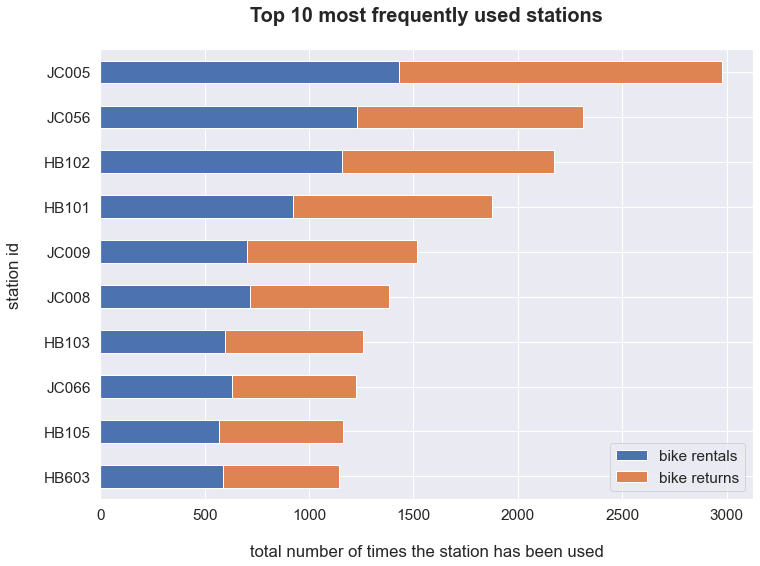

In [32]:
top10_most_popular_stations = stations.loc[(stations.start_rental_couts + stations.end_rental_couts).sort_values(ascending = False).index[0:10], :]
plot_top_stations(top10_most_popular_stations[::-1], "Top 10 most frequently used stations\n")
plt.show()

And now the ones that are not frequently used (top 10 with the smallest number of rentals & returns):

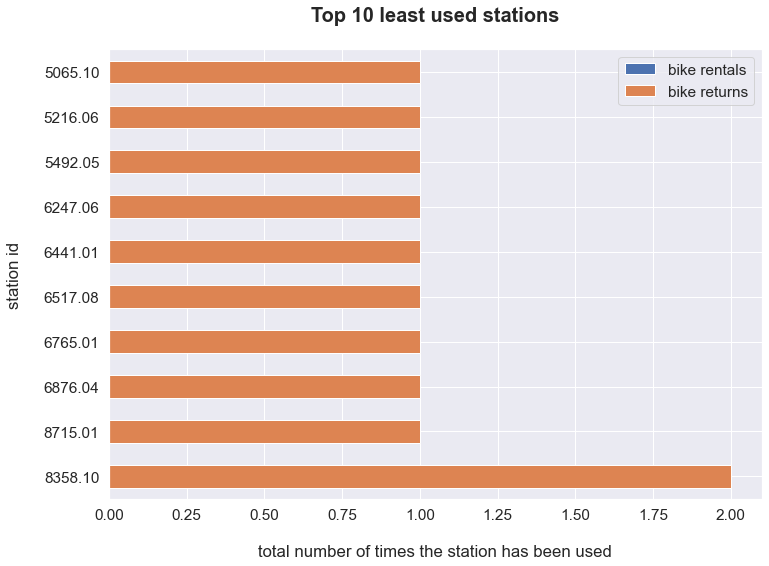

In [33]:
top10_less_popular_stations = stations.loc[(stations.start_rental_couts + stations.end_rental_couts).sort_values(ascending = True).index[0:10], :]
plot_top_stations(top10_less_popular_stations[::-1], "Top 10 least used stations\n")
plt.show()

The above plot depicts the stations that have unusual ids assigned (they may be incorrect data or e.g. newly added ones - not a lot of rentals). So let's also examine the 'real' ones - top 20.

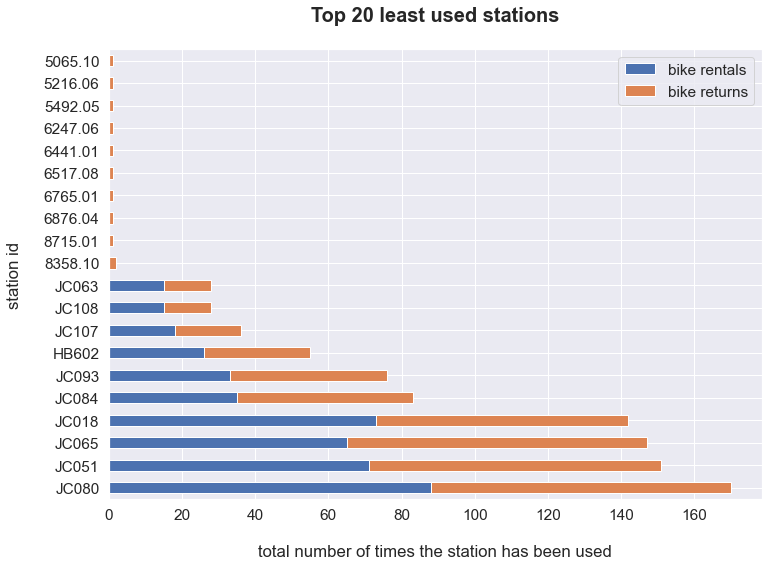

In [34]:
top20_less_popular_stations = stations.loc[(stations.start_rental_couts + stations.end_rental_couts).sort_values(ascending = True).index[0:20], :]
plot_top_stations(top20_less_popular_stations[::-1], "Top 20 least used stations\n")
plt.show()

Let's now compare top 20 most frequently used stations and 20 less common (with the "unusual id" skipped) on a single plot:

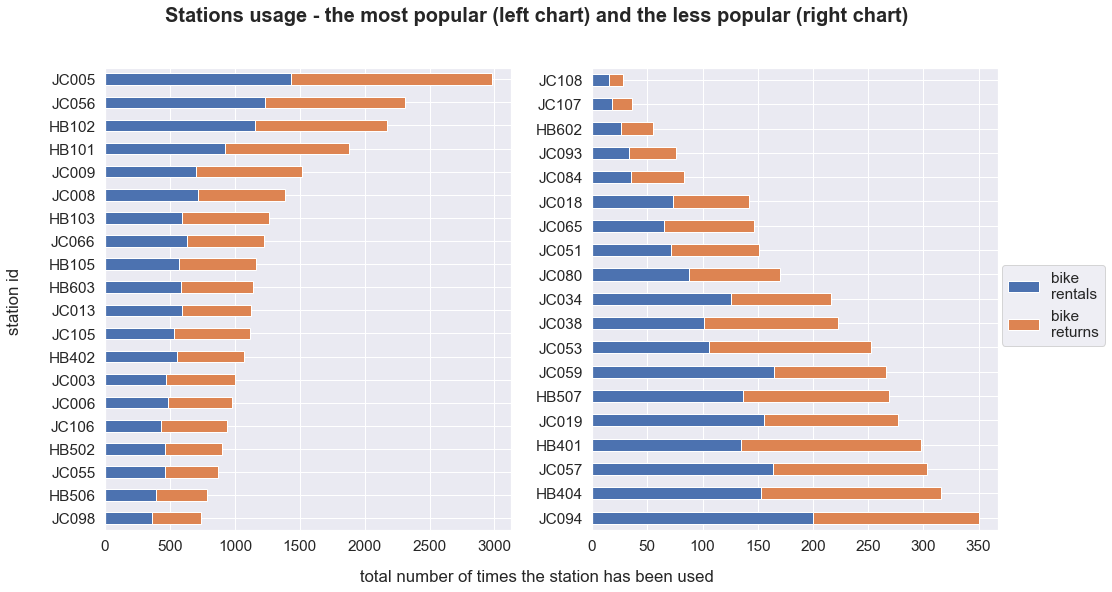

In [35]:
top20_most_popular_stations = stations.loc[(stations.start_rental_couts + stations.end_rental_couts).sort_values(ascending = False).index[0:20], :]
top20_less_popular_stations = stations.loc[(stations.start_rental_couts + stations.end_rental_couts).sort_values(ascending = True).index[11:30], :]

fig, axes = plt.subplots(1, 2, figsize=(16,8.5)) 
top20_most_popular_stations[::-1].plot.barh(ax=axes[0], legend = None, stacked = True)
top20_less_popular_stations[::-1].plot.barh(ax=axes[1], legend = None, stacked = True)
fig.suptitle("Stations usage - the most popular (left chart) and the less popular (right chart)", fontsize=20, weight="bold")
fig.text(0.5, 0.04, "\ntotal number of times the station has been used", ha="center")
fig.text(0.04, 0.5, "station id\n", va="center", rotation="vertical")
fig.legend(["bike\nrentals", "bike\nreturns"], bbox_to_anchor=(1,0.57))

From the scales of above plots we can notice that the most common stations are almost 10 times more frequently used (3000 rentals/returns) than the the less popular (300 rentals/returns). What's more, numbers of rentals/returns for each station are similar, which is a positive feedback implying there won't be the need to transport bikes from one station to another.

### Ride types analysis

Let's analyze the fraction of particular rideable types used. We see that almost all rides used "classic_bike" type: 

Text(0.5, 1.0, 'Rideable type fractions')

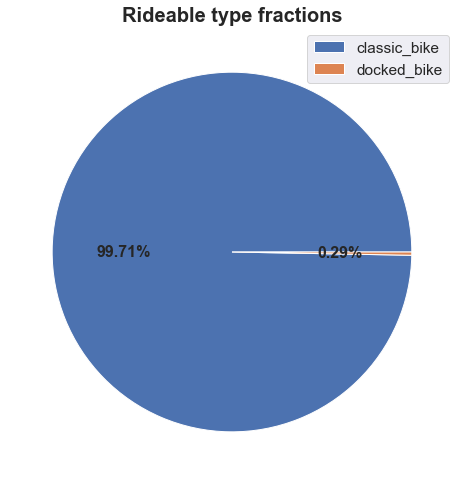

In [36]:
plt.pie(rides_by_rideable_type, autopct = '%.2f%%', textprops=dict(fontsize=16, weight='bold'))
plt.legend(rides_by_rideable_type.index)
plt.title("Rideable type fractions", weight="bold", fontsize = 20)

Ride type that is the most common is "member" (around 75%). "Casual" is about 25% of all rides:

Text(0.5, 1.0, 'Ride type fractions')

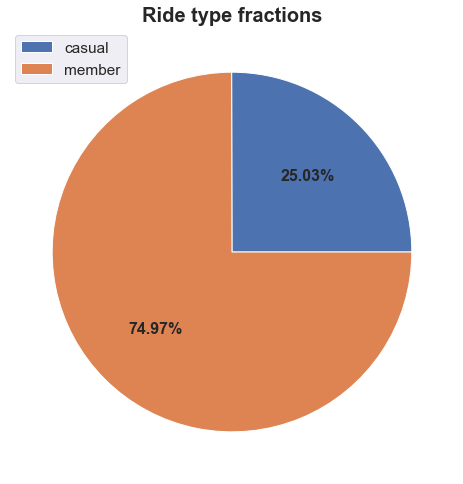

In [37]:
plt.pie(rides_by_member_casual, autopct = '%.2f%%', textprops=dict(fontsize=16, weight='bold'))
plt.legend(rides_by_member_casual.index)
plt.title("Ride type fractions", weight="bold", fontsize = 20)

### Ride properties analysis

In this section I analyze the duration, displacement and average displacement speed of each ride. 

In [38]:
def plot_hist(data, title, xlab, ylab):
    ax = sns.histplot(data, bins=30)
    ax.set_xlabel("\n" + xlab)
    ax.set_ylabel(ylab+"\n")
    ax.set_title(title+"\n",  weight="bold", fontsize = 20)
    return ax

def plot_boxplot(data, title, xlab):
    ax = sns.boxplot(x=data)
    ax.set_xlabel("\n" + xlab)
    ax.set_title(title+"\n",  weight="bold", fontsize = 20)
    return ax

Firstly, let's try to draw a boxplot and histogram of rides duration. 

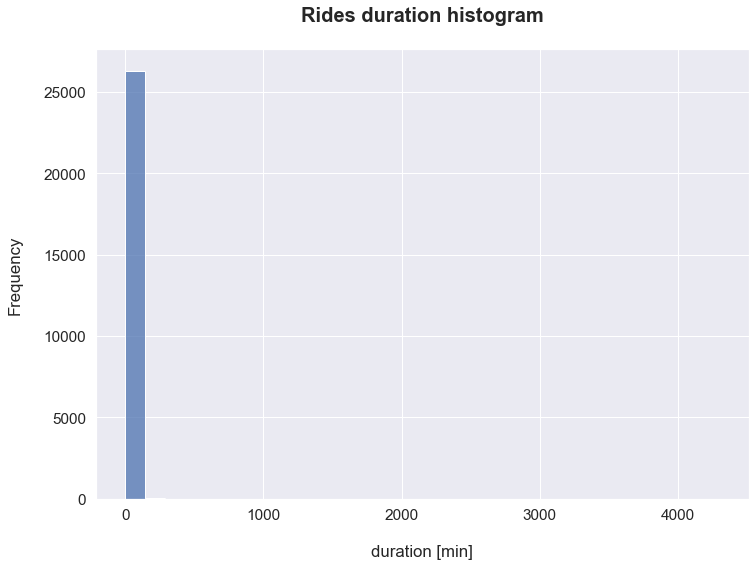

In [39]:
plot_hist(ride_info.duration_in_min, "Rides duration histogram", "duration [min]", "Frequency")
plt.show()

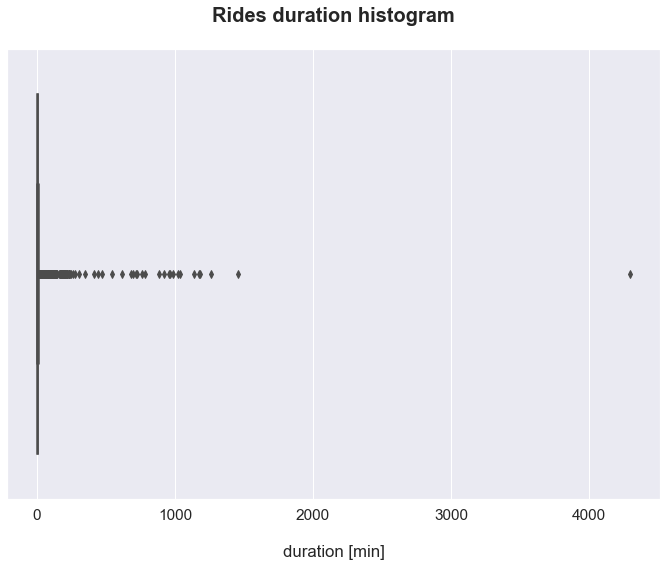

In [40]:
plot_boxplot(ride_info.duration_in_min, "Rides duration histogram", "duration [min]")
plt.show()

The results aren't visible, since there are a lot of outliers in the data. Let's try to remove extremely high values (based on quantile 0.99).

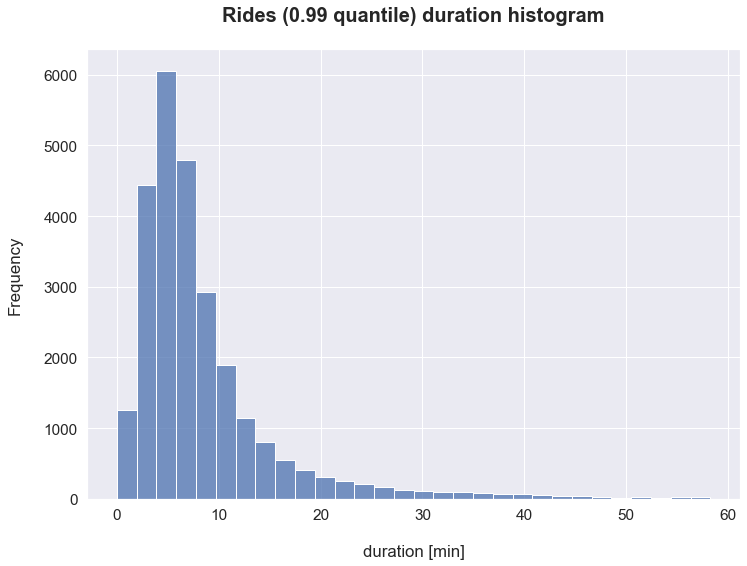

In [41]:
q0_99 = np.quantile(ride_info.duration_in_min, 0.99)
plot_hist(ride_info.duration_in_min[ride_info.duration_in_min <= q0_99], "Rides (0.99 quantile) duration histogram", "duration [min]", "Frequency")
plt.show()

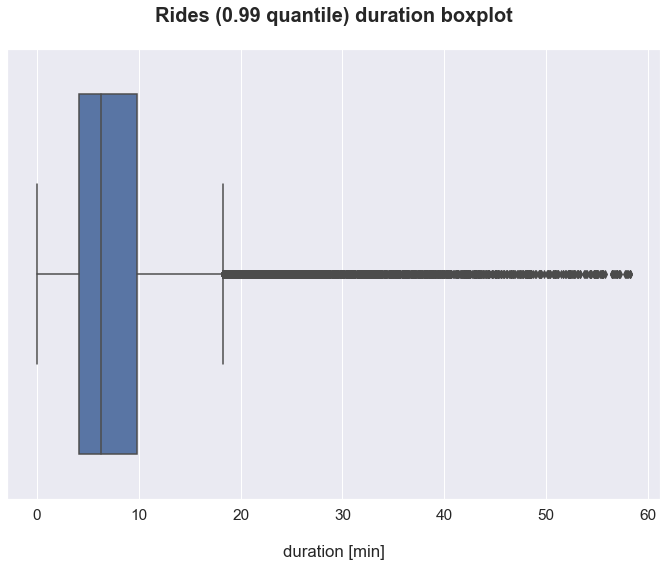

In [43]:
plot_boxplot(ride_info.duration_in_min[ride_info.duration_in_min <= q0_99], "Rides (0.99 quantile) duration boxplot", "duration [min]")
plt.show()

It is better now. We see that the median is around 5-7 minutes and the majority of rides are rather short (4-10 minutes). But quite frequent are also longer rentals (60 minutes, and in some cases even over 1000 - the previous plots). It is justified that we have outliers only above the median (people usually do not rent a bike for a minute or two, but for a couple of hours - sometimes). 

Then, an interesting thing is also the displacement (shortest distance between start and end stations):

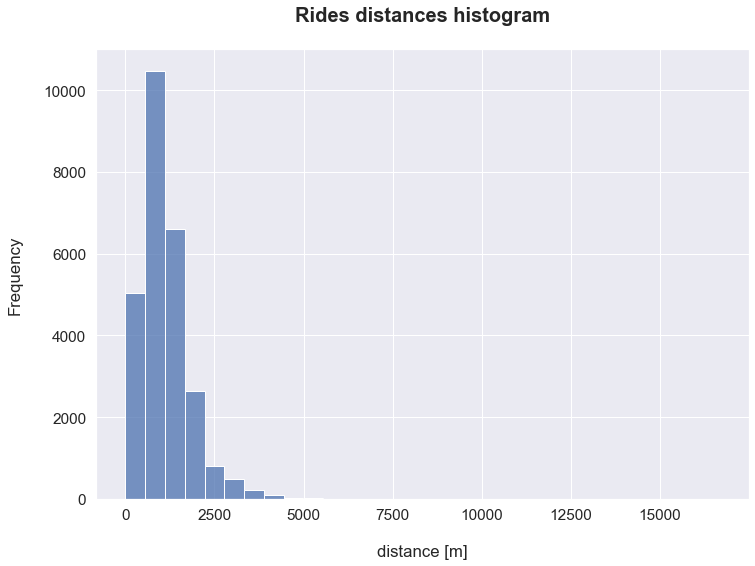

In [44]:
plot_hist(ride_info.dist_in_m, "Rides distances histogram", "distance [m]", "Frequency")
plt.show()

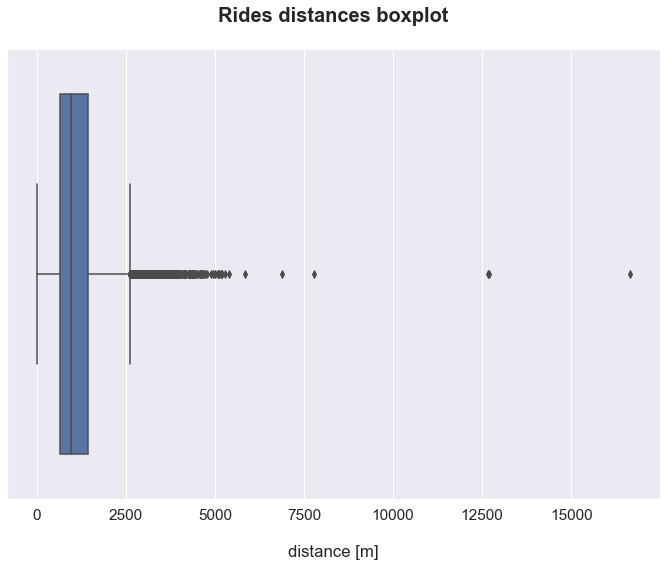

In [45]:
plot_boxplot(ride_info.dist_in_m, "Rides distances boxplot", "distance [m]")
plt.show()

Again we see that the distances are rather small. The analysis would be similar to the duration considerations. 

Lastly, let's take into account the average displacement speed [km/h]: 

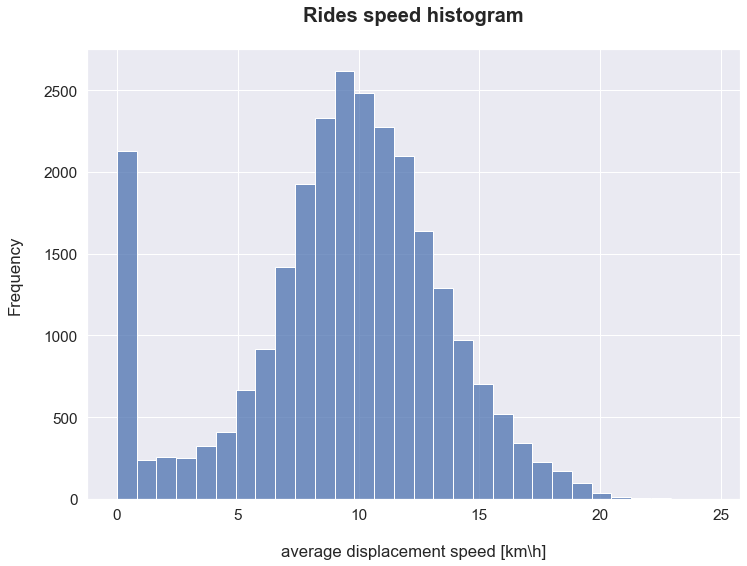

In [46]:
plot_hist(ride_info.speed_km_per_h, "Rides speed histogram", "average displacement speed [km\h]", "Frequency")
plt.show()

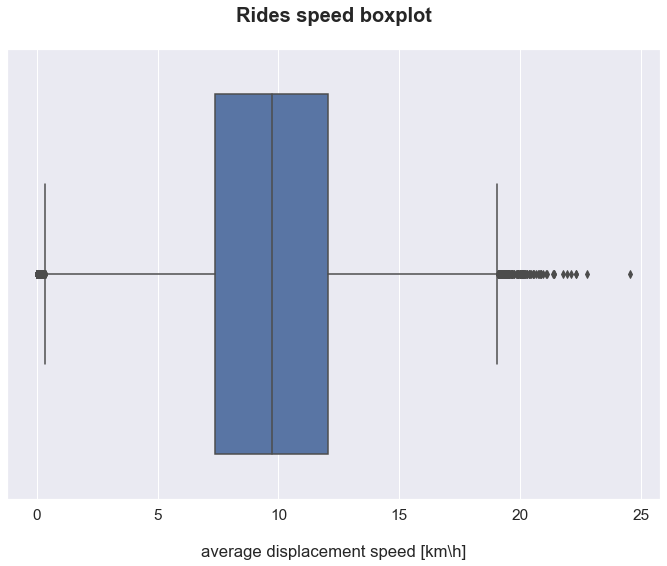

In [47]:
plot_boxplot(ride_info.speed_km_per_h, "Rides speed boxplot", "average displacement speed [km\h]")
plt.show()

The median of speeds is around 10 km/h which is a reasonable. We should also bear in mind that the real speed (not the displacement speed) would be probably greater, since the real distance of the ride is probably longer. The zero speed data is the result of renting and returning a bike in the same station (0 km distance). 

Now, I will consider the relationship between the distance and the duration of each ride:

C:\Users\gozde\.conda\envs\dev_proj\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'distance [m]\n')

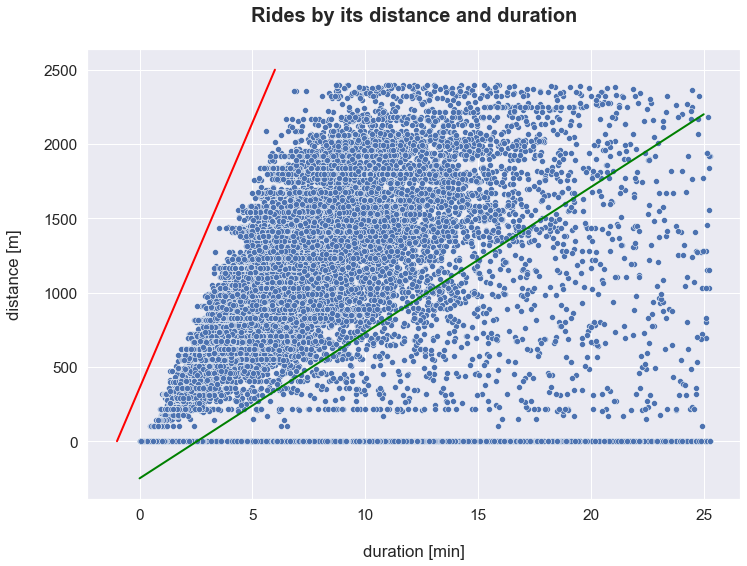

In [48]:
q_dur = np.quantile(ride_info.duration_in_min, 0.95)
q_dist = np.quantile(ride_info.dist_in_m, 0.95)
dur_dist = ride_info.loc[(ride_info.duration_in_min <= q_dur) & (ride_info.dist_in_m <= q_dist), ["duration_in_min", "dist_in_m"]]
ax = sns.scatterplot(dur_dist.duration_in_min, dur_dist.dist_in_m)
ax.plot([-1, 6], [0, 2500], c='red', linewidth=2)
ax.plot([0, 25], [-250, 2200], c='green', linewidth=2)
ax.set_title("Rides by its distance and duration\n", fontsize=20, weight="bold")
ax.set_xlabel("\nduration [min]")
ax.set_ylabel("distance [m]\n")

The above scatterplot shows that there are a limit line (red one in the plot). There is no data above this line - there is a limited speed you can get on the bike and it is depicted by the red line in the distance vs duration chart. Similarly, the majority of the points is located between red and green lines. It shows that people rarely ride very slowly (below the green line). However, here we have data points below the green line (in contrary to the red one). It is caused by the fact that sometimes you stop for some time while riding and it influences your speed. Zero distance data points mean the bike was rented and returned in the same station.  

Lastly, the analysis of the duration of rides according to the day of the week and the hour:

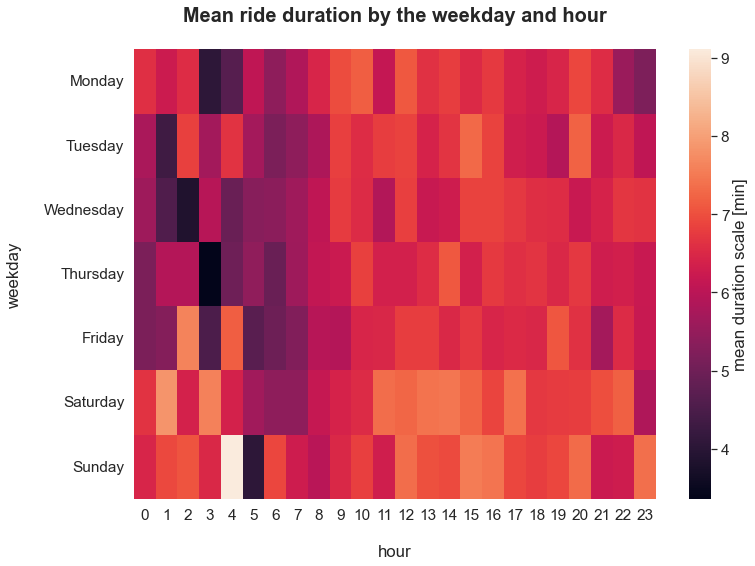

In [49]:
pivoted_data = ride_meanduration_by_weekday_and_hour.reset_index().pivot(columns='hour',index='weekday',values='duration').rename(index = number_to_weekday)
ax = sns.heatmap(pivoted_data)
ax.set_title("Mean ride duration by the weekday and hour\n", fontsize=20, weight="bold")
ax.set_ylabel("weekday\n")
ax.set_xlabel("\nhour")
ax.collections[0].colorbar.set_label("mean duration scale [min]")
plt.show()

We see that during the night, rides are usually shorter (4-5 mins vs 7-9 mins during the day). But what's interesting - during the weekend (Saturday, Sunday), night rides are longer than in the other days (7-8 mins vs 4-5 mins). Probably coming back from the party takes a bit more time ;). 

## Summary

Citi Bikes data can provide numerous interesting observations. In this report, numpy, pandas libraries were used to aggregte the data and matplotlib, seaborn to viusualize it. 